# Summary

Several `NLP` methods were used and explored here, including simple Term Frequency count using `CountVectorizer`, `TF-IDF`, and `LSA components`. These vectorizations of the tweet data were used as input for several machine learning algorithms, namely `Ridge` (Linear Regression, essentially) and `LSTM neural networks` (both normal and bi-directional). Topic Modeling was also briefly explored through the use of PyCaret's `LDA models` (but topic modeling probably isn't too important here). 

What we didn't explore here was utilizing other tweet-descriptive features in combination with the actual tweet in our models. Examples of other features would be:

* Location, location, location -  If a location was given, it may signify and correlate to a real event.
* Don't @ me! - Using the account name following the @ sign. We could perhaps even do some topic modeling on these names to further condense the data to something more categorical, and associate those to each tweet.
* "like !!!" - Excessive use of punctuation may give signifiance to a tweet describing a non-real diasaster.


See the complete Results section near the bottom of this notebook. Thank you!

# Competition Description

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

<img src="./supp/tweet_screenshot.png" alt="tweet_ss" width="200"/>

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

https://www.kaggle.com/c/nlp-getting-started/overview

In [1]:
def submission(file_name, model, X_test, sub_id):

    Y_test = model.predict(X_test)

    submission = pd.DataFrame({
        "id": sub_id, 
        "target": Y_test
    })
    submission.to_csv(file_name, index=False)

## NLP Tutorial

#### NOTE: The following 'tutorial' is from Kaggle - I adjusted where necessary, then did my own work on Ridge overfitting, exploring TF_IDF vectorization, LSA, and LSTMs. Enjoy!

NLP - or *Natural Language Processing* - is shorthand for a wide array of techniques designed to help machines learn from text. Natural Language Processing powers everything from chatbots to search engines, and is used in diverse tasks like sentiment analysis and machine translation.

In this tutorial we'll look at this competition's dataset, use a simple technique to process it, build a machine learning model, and submit predictions for a score!

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [3]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [4]:
train_df.tweet

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### A quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [115]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

And one that is:

In [116]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

In [117]:
print("Train shape: {}".format(train_df.shape))
print("Test shape: {}".format(test_df.shape))

Train shape: (7613, 5)
Test shape: (3263, 4)


### Building vectors

The theory behind the model we'll build in this tutorial is pretty simple: the words contained in each tweet are a good indicator of whether they're about a real disaster or not (this is not entirely correct, but it's a great place to start).

We'll use scikit-learn's `CountVectorizer` to count the words in each tweet and turn them into data our machine learning model can process.

Note: a `vector` is, in this context, a set of numbers that a machine learning model can work with. We'll look at one in just a second.

In [147]:
count_vectorizer_example = feature_extraction.text.CountVectorizer()

## let's get counts for the first 5 tweets in the data
example_train_vectors = count_vectorizer_example.fit_transform(train_df["text"][0:5])

In [148]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(example_train_vectors[0].todense().shape)
print(example_train_vectors[0].todense())

(1, 54)
[[0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0
  0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [149]:
train_df['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

The above tells us that:
1. There are 54 unique words (or "tokens") in the first 5 tweets.
2. The first tweet contains only some of those unique tokens - all of the non-zero counts above are the tokens that DO exist in the first tweet.

Let's print out each of the 5 tweets and the associated tokens that `CountVectorizer()` found.

In [150]:
pd.DataFrame(example_train_vectors.toarray(),index=train_df["text"][0:5],columns=count_vectorizer_example.get_feature_names())

,000,13,alaska,all,allah,are,as,asked,being,by,...,sask,school,sent,shelter,smoke,the,this,to,us,wildfires
text,,,,,,,,,,,,,,,,,,,,,
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,1,1,0,1,0
Forest fire near La Ronge Sask. Canada,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0,0,0,1,0,2,0,1,1,1,...,0,0,0,2,0,0,0,1,0,0
"13,000 people receive #wildfires evacuation orders in California",1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0,0,1,0,0,0,1,0,0,0,...,0,1,1,0,1,0,1,0,0,1


In [151]:
train_df["text"][0:5].apply(lambda x: len(x.split())).sum()

66

And based on the above, we know there were a total of 66 words across the 5 tweets - but 54 unique words! We can summarize by saying that `CountVectorizer()` enables us to understand the frequency of words (as shown above), but doesn't include semantics (how a word can take on a different meaning based on the words around it).

An example would be of a document that contains the word **good**. The word by itself is positive, but can take on a negative meaning if proceeded by the word **not** - that's not good! `CountVectorizer()` is simply a 'bag of words' technique, curated as a sparse matrix, and readable for a machine.

Now let's create vectors for all of our tweets based solely on `CountVectorizer()`.

In [193]:
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(train_df["text"])

## note that we're NOT using .fit_transform() here. Using just .transform() makes sure
# that the tokens in the train vectors are the only ones mapped to the test vectors - 
# i.e. that the train and test vectors use the same set of tokens.
test_vectors = count_vectorizer.transform(test_df["text"])

### Our model

As we mentioned above, we think the words contained in each tweet are a good indicator of whether they're about a real disaster or not. The presence of particular word (or set of words) in a tweet might link directly to whether or not that tweet is real.

What we're assuming here is a _linear_ connection. So let's build a linear model and see!

In [194]:
## Our vectors are really big, so we want to push our model's weights
## toward 0 without completely discounting different words - ridge regression 
## is a good way to do this.
clf = linear_model.RidgeClassifier()

Let's test our model and see how well it does on the training data. For this we'll use `cross-validation` - where we train on a portion of the known data, then validate it with the rest. If we do this several times (with different portions) we can get a good idea for how a particular model or method performs.

The metric for this competition is F1 (a good balance of precision and recall), so let's use that here.

In [196]:
scores = model_selection.cross_validate(clf, train_vectors, train_df["target"], cv=3, scoring="f1",
                                       return_train_score=True)

In [197]:
scores

{'fit_time': array([0.05385566, 0.04886889, 0.05086327]),
 'score_time': array([0.00099683, 0.00099778, 0.00099778]),
 'test_score': array([0.59453669, 0.56498283, 0.64051005]),
 'train_score': array([0.99448529, 0.99678899, 0.99425683])}

The above scores aren't terrible! It looks like our assumption will score roughly 0.65 on the leaderboard. There are lots of ways to potentially improve on this (TFIDF, LSA, LSTM / RNNs, the list is long!) - give any of them a shot!

We should note here the we are severaly overfitting! Even without plotting a learning curve, we can note that model is overfitting based on the simple differences between the train and test scores in the printed `scores` array.

In the meantime, let's do predictions on our training set and build a submission for the competition.

In [126]:
clf.fit(train_vectors, train_df["target"])

RidgeClassifier()

In [127]:
submission("ridge_submission.csv", clf, test_vectors, test_df.id)

In [128]:
#! kaggle competitions submit -c nlp-getting-started -f ridge_submission.csv -m "first submission - ridge linear regression"

Successfully submitted to Real or Not? NLP with Disaster Tweets



  0%|          | 0.00/25.4k [00:00<?, ?B/s]
100%|##########| 25.4k/25.4k [00:01<00:00, 13.9kB/s]


## Ridge Classification

We saw above that our ridge estimator was overfitting drastically. Let's see if we can tune our alpha parameter with grid searching to increase the mean f1 score on the validation set.

In [207]:
# Call GridSearch function
parameters = {'alpha':list(np.arange(0.1,10.1,0.1))}

# Parameters of pipelines can be set using ‘__’ separated parameter names:
reg_xgb_1 = model_selection.GridSearchCV(clf, param_grid=parameters, cv=3,
                        scoring='f1', return_train_score=True)
reg_xgb_1.fit(train_vectors, train_df["target"])

GridSearchCV(cv=3, estimator=RidgeClassifier(),
             param_grid={'alpha': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                                   0.7000000000000001, 0.8, 0.9, 1.0, 1.1,
                                   1.2000000000000002, 1.3000000000000003,
                                   1.4000000000000001, 1.5000000000000002, 1.6,
                                   1.7000000000000002, 1.8000000000000003,
                                   1.9000000000000001, 2.0, 2.1, 2.2,
                                   2.3000000000000003, 2.4000000000000004,
                                   2.5000000000000004, 2.6, 2.7,
                                   2.8000000000000003, 2.9000000000000004,
                                   3.0000000000000004, ...]},
             return_train_score=True, scoring='f1')

In [208]:
reg_xgb_1.best_score_, reg_xgb_1.best_params_

(0.6279130406278751, {'alpha': 6.1})

Looks like, from 0.1 to 10 for alpha, the best F1 score we can obtain is with alpha=6.1. We notice that the model is still grossly underfitting. We'll need a non-linear model that can better generalize. Let's submit this preds to Kaggle. Next, let's discover TF-IDF and its effects.

In [244]:
clf = reg_xgb_1.best_estimator_.fit(train_vectors, train_df["target"])

In [249]:
submission = pd.DataFrame({
        "id": test_df.id, 
        "target": clf.predict(test_vectors)})
submission.to_csv("ridge_6.1reg.csv", index=False)

In [250]:
#! kaggle competitions submit -c nlp-getting-started -f ridge_6.1reg.csv -m "ridge with reg"

Successfully submitted to Real or Not? NLP with Disaster Tweets



  0%|          | 0.00/25.4k [00:00<?, ?B/s]
100%|##########| 25.4k/25.4k [00:01<00:00, 15.0kB/s]


### TF-IDF

So - what is TF-IDF? Let's start with what it stands for:
TF means Term Frequency, and IDF means Inverse Document Frequency.

We define Term Frequency simply as:

$$TF = {\textrm{no. of repetitions of a word in a tweet}\over \textrm{no. of words in tweet}}$$

Using the above, we can construct a matrix mxn, where:

m: The vocabulary, or unique words/tokens among all the tweets (minus stopping words, of course!).

n: The tweet identifier.

Let's take two real tweets from the data as an example (no processing done):

**'tweet1'**: 'Forest fire near La Ronge Sask. Canada'

**'tweet2'**: 'Damage to school bus on 80 in multi car crash #BREAKING '

Thus, we have the matrix TF (3x2) as defined as:

|   | tweet1  |  tweet2 |
|---|---|---|
| forest  | 1/7  |  0 |
|  fire |  1/7 |  0  |
|  damage | 0  | 1/11 |

Forest, relief and damage are just examples of a much larger corpus of words/tokens that'd we'd find if we looked at all the tweets (and more between just these two examples!)

For Inverse Document Frequency, we can define this as:

$$IDF = log({\textrm{no. of tweets}\over \textrm{no. tweets containing the word}})$$

And thus,

|   | IDF  |
|---|---|
| forest  | log(2/1)  |
|  fire |  log(2/1) |
|  damage | log(2/1)  |


Now, let's actually compute TF-IDF! If we do matrix multiplication of these two, we'll get a 3x2 matrix:

|   | f1  | f2  |  f3 |
|---|---|---|---|
|tweet1  | 0.043  | 0.043  |  0 |
|  tweet2 | 0  | 0  | 0.027  |

What this has effectively done is show more 'importance' to words within a tweet that don't show up in other tweets. The words/tokens are **weighted** as opposed to simple term frequency counts (`CountVectorizer()`). Neat!

The cons to this approach is that we are again oblivious to sentiment.

Let's print out the TF-IDF matrix for our 5-tweet example.


In [138]:
vectorizer = TfidfVectorizer(max_df=1.0)
train_vectors = vectorizer.fit_transform(train_df['text'][0:5])

In [139]:
pd.DataFrame(train_vectors.toarray(),index=train_df["text"][0:5],columns=vectorizer.get_feature_names())

,000,13,alaska,all,allah,are,as,asked,being,by,...,sask,school,sent,shelter,smoke,the,this,to,us,wildfires
text,,,,,,,,,,,,,,,,,,,,,
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,0.000000,0.000000,0.000000,0.233361,0.289245,0.233361,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.289245,0.233361,0.000000,0.289245,0.000000
Forest fire near La Ronge Sask. Canada,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.377964,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0.000000,0.000000,0.000000,0.157740,0.000000,0.315481,0.000000,0.195515,0.195515,0.195515,...,0.000000,0.000000,0.000000,0.39103,0.000000,0.000000,0.000000,0.195515,0.000000,0.000000
"13,000 people receive #wildfires evacuation orders in California",0.362651,0.362651,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.292584
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0.000000,0.000000,0.247675,0.000000,0.000000,0.000000,0.247675,0.000000,0.000000,0.000000,...,0.000000,0.247675,0.247675,0.00000,0.247675,0.000000,0.199822,0.000000,0.000000,0.199822


Take the word `all` for example. In the term frequency before, we just had a '1' for tweets 1 and 3 as the word only appeared once in each tweet. However, in TF-IDF, tweet 1 is weighted more now because tweet 1 has *fewer words* than tweet 3 (the total number of words in a tweet is in the denominator of the tf equation.

### Ridge Classification with TF-IDF

In [34]:
vectorizer = TfidfVectorizer(max_df=1.0)
train_vectors = vectorizer.fit_transform(train_df['text'])
test_vectors = vectorizer.transform(test_df['text'])

In [252]:
clf = linear_model.RidgeClassifier(alpha=1.0)
# Call GridSearch function
parameters = {'alpha':list(np.arange(0.1,10.1,0.1))}

# Parameters of pipelines can be set using ‘__’ separated parameter names:
clf_tfidf = model_selection.GridSearchCV(clf, param_grid=parameters, cv=3,
                        scoring='f1', return_train_score=True)
clf_tfidf.fit(train_vectors, train_df["target"])

GridSearchCV(cv=3, estimator=RidgeClassifier(),
             param_grid={'alpha': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                                   0.7000000000000001, 0.8, 0.9, 1.0, 1.1,
                                   1.2000000000000002, 1.3000000000000003,
                                   1.4000000000000001, 1.5000000000000002, 1.6,
                                   1.7000000000000002, 1.8000000000000003,
                                   1.9000000000000001, 2.0, 2.1, 2.2,
                                   2.3000000000000003, 2.4000000000000004,
                                   2.5000000000000004, 2.6, 2.7,
                                   2.8000000000000003, 2.9000000000000004,
                                   3.0000000000000004, ...]},
             return_train_score=True, scoring='f1')

In [257]:
clf_tfidf.best_score_

0.6467943700027763

This already outperforms the ridge model before without TF-IDF. Nice!

In [255]:
clf_tfidf_best = clf_tfidf.best_estimator_.fit(train_vectors, train_df["target"])
submission = pd.DataFrame({
        "id": test_df.id, 
        "target": clf_tfidf_best.predict(test_vectors)})
submission.to_csv("ridge_tfidf_1.6reg.csv", index=False)

In [256]:
#! kaggle competitions submit -c nlp-getting-started -f ridge_tfidf_1.6reg.csv -m "ridge classification with tfidf and reg"


  0%|          | 0.00/25.4k [00:00<?, ?B/s]
100%|##########| 25.4k/25.4k [00:02<00:00, 9.47kB/s]


Successfully submitted to Real or Not? NLP with Disaster Tweets


We could tune our model here by adjusting the `TfidVectorizer` parameters (max_df, vocabulary, or input our own stopping words). 

## LSA (Latent Semantic Analysis)

Let's take the same 5 tweets as before and perform LSA to check similarities! 

In [497]:
# Fit LSA. Use algorithm = “randomized” for large datasets
lsa = TruncatedSVD(3)
dtm_lsa = lsa.fit_transform(example_train_vectors)
dtm_lsa = preprocessing.Normalizer(copy=False).fit_transform(dtm_lsa)

In [156]:
example_train_vectors.shape

(5, 54)

In [157]:
pd.DataFrame(lsa.components_,index = ["component_1","component_2", "component_3"],columns = count_vectorizer_example.get_feature_names())

,000,13,alaska,all,allah,are,as,asked,being,by,...,sask,school,sent,shelter,smoke,the,this,to,us,wildfires
component_1,0.031466,0.031466,0.004240,0.202587,0.028838,0.376336,0.004240,0.173749,0.173749,0.173749,...,9.722136e-17,0.004240,0.004240,0.347498,0.004240,0.028838,0.033078,0.173749,0.028838,0.035706
component_2,0.020393,0.020393,0.235213,0.026752,0.043386,0.010118,0.235213,-0.016634,-0.016634,-0.016634,...,-7.728427e-17,0.235213,0.235213,-0.033268,0.235213,0.043386,0.278599,-0.016634,0.043386,0.255606
component_3,-0.053678,-0.053678,-0.047944,0.237762,0.272018,0.203505,-0.047944,-0.034257,-0.034257,-0.034257,...,-5.079257e-17,-0.047944,-0.047944,-0.068513,-0.047944,0.272018,0.224074,-0.034257,0.272018,-0.101622


In [158]:
pd.DataFrame(dtm_lsa, index = train_df["text"][0:5], columns = ["component_1","component_2", "component_3"])

,component_1,component_2,component_3
text,,,
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,0.251329,0.209168,0.945030
Forest fire near La Ronge Sask. Canada,0.731603,-0.680164,-0.046191
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0.995539,-0.052722,-0.078243
"13,000 people receive #wildfires evacuation orders in California",0.792811,0.284236,-0.539129
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0.032225,0.988870,-0.145251


In [159]:
similarity = np.asarray(np.asmatrix(dtm_lsa) * np.asmatrix(dtm_lsa).T)
pd.DataFrame(similarity,index=train_df["text"][0:5], columns=train_df["text"][0:5]).head(10)

text,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,Forest fire near La Ronge Sask. Canada,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,"13,000 people receive #wildfires evacuation orders in California",Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school
text,,,,,
Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1.000000,-0.002047,0.165239,-0.250784,0.077672
Forest fire near La Ronge Sask. Canada,-0.002047,1.000000,0.767813,0.411599,-0.642309
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,0.165239,0.767813,1.000000,0.816472,-0.008689
"13,000 people receive #wildfires evacuation orders in California",-0.250784,0.411599,0.816472,1.000000,0.384930
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,0.077672,-0.642309,-0.008689,0.384930,1.000000


Finally! From the above, we can see a similarity matrix of our 5 tweets. The higher the similarity score, the more 'similar' the tweets. We can notice that tweets with similar words rank higher on the similary score!

### LSA (using CountVectorizer)

In [160]:
# Vectorizer
count_vectorizer = feature_extraction.text.CountVectorizer()

# For Train
train_dtm_lsa = lsa.fit_transform(count_vectorizer.fit_transform(train_df["text"]))
train_dtm_lsa = preprocessing.Normalizer(copy=False).fit_transform(train_dtm_lsa)
print("Shape of train las: {}".format(train_dtm_lsa.shape))

train_lsa_comp = pd.DataFrame(train_dtm_lsa, index = train_df["text"], columns = ["component_1","component_2", "component_3"])
train_lsa_comp.reset_index(inplace=True)

# For Test
test_dtm_lsa = lsa.fit_transform(count_vectorizer.transform(test_df["text"]))
test_dtm_lsa = preprocessing.Normalizer(copy=False).transform(test_dtm_lsa)
print("Shape of test las: {}".format(test_dtm_lsa.shape))

test_lsa_comp = pd.DataFrame(test_dtm_lsa, index = test_df["text"], columns = ["component_1","component_2", "component_3"])
test_lsa_comp.reset_index(inplace=True)

Shape of train las: (7613, 3)
Shape of test las: (3263, 3)


In [161]:
clf = linear_model.RidgeClassifier(alpha=1.0)
scores = model_selection.cross_val_score(clf, train_lsa_comp.drop(['text'], axis=1), train_df["target"], cv=3, scoring="f1")
np.mean(scores)

0.5964995525078104

This f1 score is worse than just using either term frequncy or TF-IDF on the text data. Let's see if using TF-IDF with LSA improves the validation mean.

### LSA (using TF-IDF)

In [498]:
# Vectorizer
vectorizer = TfidfVectorizer()

# For Train
train_dtm_lsa = lsa.fit_transform(vectorizer.fit_transform(train_df["text"]))
train_dtm_lsa = preprocessing.Normalizer(copy=False).fit_transform(train_dtm_lsa)
print("Shape of train las: {}".format(train_dtm_lsa.shape))

train_lsa_comp = pd.DataFrame(train_dtm_lsa, index = train_df["text"], columns = ["component_1","component_2", "component_3"])
train_lsa_comp.reset_index(inplace=True)

# For Test
test_dtm_lsa = lsa.fit_transform(vectorizer.transform(test_df["text"]))
test_dtm_lsa = preprocessing.Normalizer(copy=False).transform(test_dtm_lsa)
print("Shape of test las: {}".format(test_dtm_lsa.shape))

test_lsa_comp = pd.DataFrame(test_dtm_lsa, index = test_df["text"], columns = ["component_1","component_2", "component_3"])
test_lsa_comp.reset_index(inplace=True)

Shape of train las: (7613, 3)
Shape of test las: (3263, 3)


In [499]:
clf = linear_model.RidgeClassifier(alpha=1.0)
scores = model_selection.cross_val_score(clf, train_lsa_comp.drop(['text'], axis=1), train_df["target"], cv=3, scoring="f1")
np.mean(scores)

0.611660466085451

Better than our highest so far (TF-IDF on Tweet only, Ridge). We can probably improve by:

1. Adjusting the max_df parameter and adding stop words to our vectorizer.
2. Adjusting the number of LSA components.

We'd also need to check if we're overfitting!

Let's fit, predict and submit.

In [200]:
clf.fit(train_lsa_comp.drop(['text'], axis=1), train_df["target"])
submission("ridge_submission_LSA3_1.csv", clf, test_lsa_comp.drop(['text'], axis=1), test_df.id)

In [500]:
! kaggle competitions submit -c nlp-getting-started -f ridge_submission_LSA3_1.csv -m "ridge classification -  LSA with 3 components"

Successfully submitted to Real or Not? NLP with Disaster Tweets



  0%|          | 0.00/25.4k [00:00<?, ?B/s]
100%|##########| 25.4k/25.4k [00:02<00:00, 11.2kB/s]


## LSTM (Long Short-Term Memory)

LSTM, a type of RNN (recurrent nueral network), allows us to use information from the past to inform the present. In the context of NLP (natural language processing), a single word (or token) holds meaning unto itself, but can take on different meaning when one considers the words that come before it. RNNs can do this inherently, but can really only look at the value inputted *one step before* each word. In contrast, LSTMs have memory - they learn from all the proceeding words to infer the meaning, or sentiment, of the document. 

In this scenario, we're predicting whether the tweet is of a real disaster or not. Up to this point, we've used TF-IDF and simple item frequncy to train on and predict. Both of those vectorizaion techniques were obvlious to sentiment - what if we trained an LSTM RNN? Let's find out!

In [28]:
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, SpatialDropout1D

In [113]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '#': '# ',
                '@': '@ ',
                '\s+': ' '}
def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

def f1(history, p_name, r_name):
    p = history.history[p_name]
    r = history.history[r_name]
    p = np.array(p)
    r = np.array(r)
    return 2*(p*r)/(p+r)

In [286]:
lstm_example = train_df['text'][0:5].apply(lambda x: clean_text(x))

In [186]:
lstm_train_df = train_df['text'].apply(lambda x: clean_text(x))
lstm_test_df = test_df['text'].apply(lambda x: clean_text(x))

max phrase len between train and test: 72


Text(0, 0.5, 'probability')

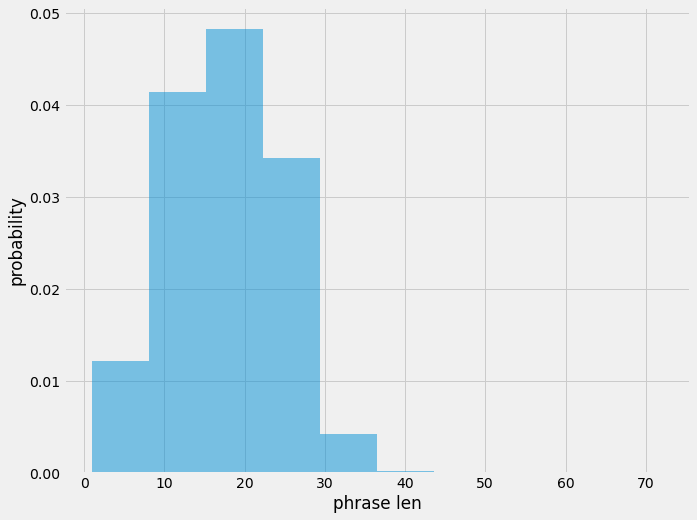

In [187]:
phrase_len_train = lstm_train_df.apply(lambda p: len(p.split(' ')))
phrase_len_test = lstm_test_df.apply(lambda p: len(p.split(' ')))
max_phrase_len_train = phrase_len_train.max()
max_phrase_len_test = phrase_len_test.max()
max_phrase_len = np.max([max_phrase_len_train, max_phrase_len_test])

print('max phrase len between train and test: {0}'.format(max_phrase_len))

plt.figure(figsize = (10, 8))
# note that phrase len used here should be the largest between train and test!
plt.hist(phrase_len_train, alpha = .5, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')

The following is used for TF-IDF - no need to pad with 0s here to ensure each tweet has the same length in the sparse matrix. TF-IDF is inherently normalized in the sense that the length of each tweet is already taken into account.

This is where we vectorize the tweets. We can choose to use Keras text preprocessor Tokenizer here. Here is where we could try different vectorizations, like TF-IDF or just a normal frequency count. We'll show the outcome of both the simple item frequency count and TF-IDF.

In [188]:
tokenizer = Tokenizer(
    num_words = 22727,
    filters = '$%&()*+-/:;<=>[\]^_`{|}~'
)
tokenizer.fit_on_texts(lstm_train_df)

# sequences - simple item frequency 
lstm_train_df = tokenizer.texts_to_sequences(lstm_train_df)
lstm_test_df = tokenizer.texts_to_sequences(lstm_test_df)

# pad sequences
lstm_train_df = pad_sequences(lstm_train_df, maxlen = max_phrase_len)
lstm_test_df = pad_sequences(lstm_test_df, maxlen = max_phrase_len)

lstm_train_target = to_categorical(train_df['target'])

### Create the model, and fit

We'll then create our LSTM model. Some important things to note:

1. We do an embedding layer that allows for:
2. We then construct the inner nueral networks
3. We set the loss function to the typical cross_entropy function, optimizer as 'Adam', and our metrics of Precision and Recall

In [152]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = 22727, output_dim = 100, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(100, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(2, activation = 'sigmoid'))
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['Precision', 'Recall']
)

In [153]:
model_lstm.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 72, 100)           2272700   
_________________________________________________________________
spatial_dropout1d_56 (Spatia (None, 72, 100)           0         
_________________________________________________________________
lstm_61 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_51 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 2)                 202       
Total params: 2,353,302
Trainable params: 2,353,302
Non-trainable params: 0
_________________________________________________________________


In [154]:
history = model_lstm.fit(
    lstm_train_df,
    lstm_train_target,
    validation_split = 0.1,
    epochs = 6,
    batch_size = 256
)

Epoch 1/6
27/27 [==============================] - 10s 374ms/step - loss: 0.6683 - precision: 0.5827 - recall: 0.5846 - val_loss: 0.6246 - val_precision: 0.6935 - val_recall: 0.6890
Epoch 2/6
27/27 [==============================] - 9s 351ms/step - loss: 0.5388 - precision: 0.7365 - recall: 0.7390 - val_loss: 0.4657 - val_precision: 0.8003 - val_recall: 0.7992
Epoch 3/6
27/27 [==============================] - 9s 350ms/step - loss: 0.3549 - precision: 0.8567 - recall: 0.8561 - val_loss: 0.4387 - val_precision: 0.8011 - val_recall: 0.7979
Epoch 4/6
27/27 [==============================] - 9s 339ms/step - loss: 0.2524 - precision: 0.9071 - recall: 0.9067 - val_loss: 0.4753 - val_precision: 0.8000 - val_recall: 0.7979
Epoch 5/6
27/27 [==============================] - 9s 336ms/step - loss: 0.1743 - precision: 0.9404 - recall: 0.9390 - val_loss: 0.5117 - val_precision: 0.7852 - val_recall: 0.7822
Epoch 6/6
27/27 [==============================] - 9s 349ms/step - loss: 0.1321 - precision: 0

In [155]:
f1_train = f1(history, "precision", "recall")
f1_valid = f1(history, "val_precision", "val_recall")

In [156]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)

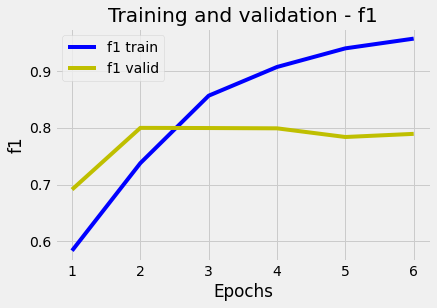

In [157]:
plt.clf()
f1_train = f1_train
f1_valid = f1_valid
plt.plot(epochs, f1_train, 'b', label='f1 train')
plt.plot(epochs, f1_valid, 'y', label='f1 valid')
plt.title('Training and validation - f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.legend()
plt.show()

In [158]:
print ("F1 score at last epoch: {}".format(f1_valid[-1]))

F1 score at last epoch: 0.7892317945717054


In the above learning curve, we can see that we're overfitting. We can try and adjust:

1. Reduce number of hidden units. Rule of thumb is to have hidden units between number of classes (2) and input dims (72).
2. Increase dropout rate.
3. Adjust text vectorization (num of words, stopping words, special chars, etc.)

Here we reduce the number of hidden units (from 100 to 28), and increase the dropout rate.

In [179]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = 22727, output_dim = 72, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.5))
model_lstm.add(LSTM(28, dropout = 0.5, recurrent_dropout = 0.5))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(2, activation = 'sigmoid'))
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['Precision', 'Recall']
)

In [180]:
history = model_lstm.fit(
    lstm_train_df,
    lstm_train_target,
    validation_split = 0.1,
    epochs = 6,
    batch_size = 256
)

Epoch 1/6
27/27 [==============================] - 6s 232ms/step - loss: 0.6829 - precision: 0.5670 - recall: 0.5529 - val_loss: 0.6749 - val_precision: 0.5341 - val_recall: 0.5341
Epoch 2/6
27/27 [==============================] - 5s 188ms/step - loss: 0.6437 - precision: 0.6222 - recall: 0.6157 - val_loss: 0.6125 - val_precision: 0.7184 - val_recall: 0.6864
Epoch 3/6
27/27 [==============================] - 5s 199ms/step - loss: 0.5676 - precision: 0.7385 - recall: 0.7230 - val_loss: 0.5321 - val_precision: 0.7647 - val_recall: 0.7507
Epoch 4/6
27/27 [==============================] - 5s 198ms/step - loss: 0.4542 - precision: 0.8184 - recall: 0.8145 - val_loss: 0.4529 - val_precision: 0.8029 - val_recall: 0.7966
Epoch 5/6
27/27 [==============================] - 5s 194ms/step - loss: 0.3514 - precision: 0.8715 - recall: 0.8656 - val_loss: 0.4488 - val_precision: 0.8061 - val_recall: 0.7913
Epoch 6/6
27/27 [==============================] - 5s 179ms/step - loss: 0.2971 - precision: 0.

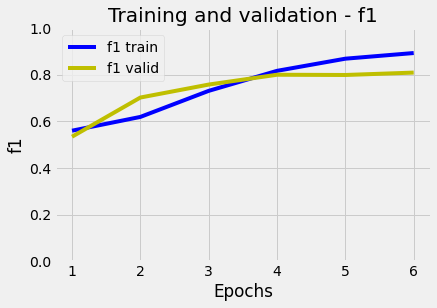

In [181]:
f1_train = f1(history, "precision", "recall")
f1_valid = f1(history, "val_precision", "val_recall")

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.clf()
f1_train = f1_train
f1_valid = f1_valid
plt.plot(epochs, f1_train, 'b', label='f1 train')
plt.plot(epochs, f1_valid, 'y', label='f1 valid')
plt.title('Training and validation - f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.ylim(0,1)
plt.legend()
plt.show()

In [182]:
print ("F1 score at last epoch: {}".format(f1_valid[-1]))

F1 score at last epoch: 0.8089297502701969


That looks better! Let's make predictions and submit.

In [183]:
preds = model_lstm.predict_classes(lstm_test_df)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [184]:
submission = pd.DataFrame({
        "id": test_df.id, 
        "target": preds})
submission.to_csv("LSTM_28u_0.5dr.csv", index=False)

In [185]:
#! kaggle competitions submit -c nlp-getting-started -f LSTM_28u_0.5dr.csv -m "LSTM v1 - 28 units, 0.5 dropout"

Successfully submitted to Real or Not? NLP with Disaster Tweets



  0%|          | 0.00/25.4k [00:00<?, ?B/s]
100%|##########| 25.4k/25.4k [00:02<00:00, 12.6kB/s]


## LSTM with TF-IDF

In [124]:
tokenizer = Tokenizer(
    filters = '$%&()*+-/:;<=>[\]^_`{|}~'
)
tokenizer.fit_on_texts(lstm_train_df)
lstm_train_df = tokenizer.texts_to_matrix(lstm_train_df, mode='tfidf')
lstm_test_df = tokenizer.texts_to_matrix(lstm_test_df, mode='tfidf')

lstm_train_target = to_categorical(train_df['target'])

There is no need for an embedding layer for our TF-IDF matrix. However, we will need to now convert our 2D matrix to 3D since that's required in the first layer of an RNN. We can do this be usiing reshape.

In [125]:
lstm_train_df = lstm_train_df.reshape(lstm_train_df.shape[0], 1, lstm_train_df.shape[1])
lstm_test_df = lstm_test_df.reshape(lstm_test_df.shape[0], 1, lstm_test_df.shape[1])

In [132]:
# Model
model_lstm = Sequential()
model_lstm.add(SpatialDropout1D(0.5))
model_lstm.add(LSTM(28, dropout = 0.5, recurrent_dropout = 0.5, 
                    input_shape=(lstm_train_df.shape[1:])))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(2, activation = 'sigmoid'))
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['Precision', 'Recall']
)

# fit
history = model_lstm.fit(
    lstm_train_df,
    lstm_train_target,
    validation_split = 0.1,
    epochs = 6,
    batch_size = 256
)

Epoch 1/6
21/21 [==============================] - 6s 308ms/step - loss: 0.6801 - precision: 0.5811 - recall: 0.5905 - val_loss: 0.6583 - val_precision: 0.7027 - val_recall: 0.7141
Epoch 2/6
21/21 [==============================] - 6s 278ms/step - loss: 0.6319 - precision: 0.6898 - recall: 0.6902 - val_loss: 0.6192 - val_precision: 0.7403 - val_recall: 0.7465
Epoch 3/6
21/21 [==============================] - 5s 252ms/step - loss: 0.5807 - precision: 0.7366 - recall: 0.7399 - val_loss: 0.5783 - val_precision: 0.7686 - val_recall: 0.7706
Epoch 4/6
21/21 [==============================] - 5s 253ms/step - loss: 0.5294 - precision: 0.7706 - recall: 0.7703 - val_loss: 0.5439 - val_precision: 0.7800 - val_recall: 0.7824
Epoch 5/6
21/21 [==============================] - 6s 271ms/step - loss: 0.4891 - precision: 0.7862 - recall: 0.7859 - val_loss: 0.5209 - val_precision: 0.7812 - val_recall: 0.7815
Epoch 6/6
21/21 [==============================] - 6s 276ms/step - loss: 0.4429 - precision: 0.

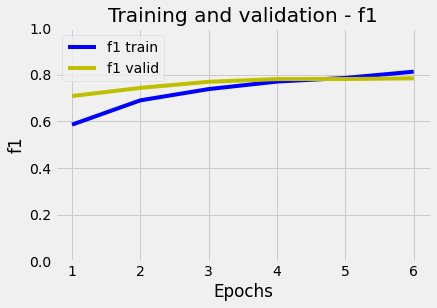

In [133]:
f1_train = f1(history, "precision", "recall")
f1_valid = f1(history, "val_precision", "val_recall")

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.clf()
f1_train = f1_train
f1_valid = f1_valid
plt.plot(epochs, f1_train, 'b', label='f1 train')
plt.plot(epochs, f1_valid, 'y', label='f1 valid')
plt.title('Training and validation - f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.ylim(0,1)
plt.legend()
plt.show()

In [134]:
print ("F1 score at last epoch: {}".format(f1_valid[-1]))

F1 score at last epoch: 0.7842794758650533


Using TF-IDF vectorization, we did not beat our best score achieved using just simple term freq count. Let's introduce Bi-LSTMs next.

### Bi-LSTM

Let's adjust the existing LSTM layer to be bidirectional. In contrast to a traditional LSTM, bidirectional LSTMs look forward in the sequence to the following word (not only the proceeding words!). This helps when the same word in a tweet can take on a different meaning in a different tweet, but where the words succeeding it hold signifiance in its meaning.

#### Bi-LSTM with TF-IDF

In [120]:
# Model - bi-lstm
model_lstm = Sequential()
model_lstm.add(SpatialDropout1D(0.5))
model_lstm.add(Bidirectional(LSTM(34, return_sequences=False,
                                  dropout = 0.5, recurrent_dropout = 0.5, 
                    input_shape=(lstm_train_df.shape[1:]))))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(2, activation = 'sigmoid'))
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['Precision', 'Recall']
)

# fit
history = model_lstm.fit(
    lstm_train_df,
    lstm_train_target,
    validation_split = 0.1,
    epochs = 6,
    batch_size = 256
)

Epoch 1/6
27/27 [==============================] - 10s 386ms/step - loss: 0.6641 - precision: 0.6132 - recall: 0.6217 - val_loss: 0.6191 - val_precision: 0.7581 - val_recall: 0.7402
Epoch 2/6
27/27 [==============================] - 9s 330ms/step - loss: 0.5734 - precision: 0.7485 - recall: 0.7437 - val_loss: 0.5404 - val_precision: 0.7882 - val_recall: 0.7913
Epoch 3/6
27/27 [==============================] - 9s 345ms/step - loss: 0.4904 - precision: 0.7961 - recall: 0.7984 - val_loss: 0.4862 - val_precision: 0.7982 - val_recall: 0.7940
Epoch 4/6
27/27 [==============================] - 9s 341ms/step - loss: 0.4385 - precision: 0.8233 - recall: 0.8196 - val_loss: 0.4631 - val_precision: 0.7971 - val_recall: 0.7992
Epoch 5/6
27/27 [==============================] - 9s 333ms/step - loss: 0.3965 - precision: 0.8337 - recall: 0.8313 - val_loss: 0.4528 - val_precision: 0.7908 - val_recall: 0.7940
Epoch 6/6
27/27 [==============================] - 9s 335ms/step - loss: 0.3715 - precision: 0

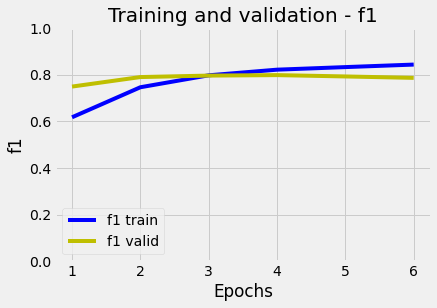

In [121]:
f1_train = f1(history, "precision", "recall")
f1_valid = f1(history, "val_precision", "val_recall")

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.clf()
f1_train = f1_train
f1_valid = f1_valid
plt.plot(epochs, f1_train, 'b', label='f1 train')
plt.plot(epochs, f1_valid, 'y', label='f1 valid')
plt.title('Training and validation - f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.ylim(0,1)
plt.legend()
plt.show()

In [122]:
f1_valid[-1]

0.7863248096412958

#### Bi-LSTM with Term Freq Count

In [189]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = 22727, output_dim = 72, input_length = max_phrase_len))
model_lstm.add(SpatialDropout1D(0.5))
model_lstm.add(Bidirectional(LSTM(28, return_sequences=False,
                                  dropout = 0.5, recurrent_dropout = 0.5)))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(2, activation = 'sigmoid'))
model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['Precision', 'Recall']
)

# fit
history = model_lstm.fit(
    lstm_train_df,
    lstm_train_target,
    validation_split = 0.1,
    epochs = 6,
    batch_size = 256
)

Epoch 1/6
27/27 [==============================] - 9s 344ms/step - loss: 0.6850 - precision: 0.5570 - recall: 0.5501 - val_loss: 0.6843 - val_precision: 0.5341 - val_recall: 0.5341
Epoch 2/6
27/27 [==============================] - 8s 302ms/step - loss: 0.6468 - precision: 0.6054 - recall: 0.6101 - val_loss: 0.6073 - val_precision: 0.7019 - val_recall: 0.7139
Epoch 3/6
27/27 [==============================] - 8s 282ms/step - loss: 0.5623 - precision: 0.7484 - recall: 0.7476 - val_loss: 0.5257 - val_precision: 0.7824 - val_recall: 0.7927
Epoch 4/6
27/27 [==============================] - 8s 285ms/step - loss: 0.4514 - precision: 0.8285 - recall: 0.8291 - val_loss: 0.4723 - val_precision: 0.7874 - val_recall: 0.7874
Epoch 5/6
27/27 [==============================] - 7s 266ms/step - loss: 0.3613 - precision: 0.8672 - recall: 0.8711 - val_loss: 0.4489 - val_precision: 0.8073 - val_recall: 0.8084
Epoch 6/6
27/27 [==============================] - 8s 298ms/step - loss: 0.3016 - precision: 0.

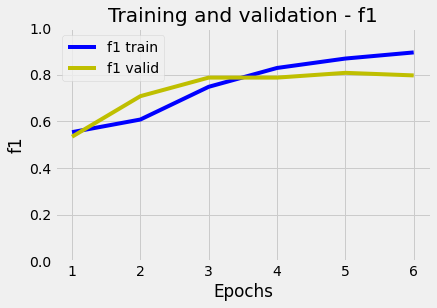

In [190]:
f1_train = f1(history, "precision", "recall")
f1_valid = f1(history, "val_precision", "val_recall")

loss = history.history['loss']
epochs = range(1, len(loss) + 1)

plt.clf()
f1_train = f1_train
f1_valid = f1_valid
plt.plot(epochs, f1_train, 'b', label='f1 train')
plt.plot(epochs, f1_valid, 'y', label='f1 valid')
plt.title('Training and validation - f1')
plt.xlabel('Epochs')
plt.ylabel('f1')
plt.ylim(0,1)
plt.legend()
plt.show()

In [191]:
print ("F1 score at last epoch: {}".format(f1_valid[-1]))

F1 score at last epoch: 0.7968545279649702


Let's compare all the models we've trained below and give some final thoughts and next steps.

## Comparing Kaggle Results 

Summarize here:
1. The validation F1 scores for all the submitted models
2. Compare those scores to the holdout on Kaggle.
3. Talk about why LSTM model generalized so well with the holdout set (valid and test were very close), as opposed to Ridge TF-IDF and others having large valid/test disparities.

### LSTM - Results

Adjusting hidden units, dropout, batch_size and epochs, we came to the conclusion that getting an F1 score on the validation set above 0.82 proved difficult. See the following table:

<img src="./supp/lstm_results.png" alt="lsmt_results" width="800"/>

Note that several other combinations of the above parameters (units, dropout, etc.) were tried but not shown in the summary table above. Of all the LSTM models tests, LSTM with Term Freq Count vectorization yielded the best F1 score on the validation set. We ensured that the model *did not overfit* by plotting learning curves of the F1 score over epochs. We can sort of compliment ourselves on the overfitting aspect by submitting our scores to Kaggle and looking at the F1 score reported.  

<img src="./supp/lstm_best_kaggle.png" alt="lsmt_results" width="800"/>

The F1 score from our best LSTM model was roughly 2% off from the holdout score reported by Kaggle. Nice! This means we generalized well enough for the unseen holdout data (and were thus not susceptible to over/under fitting).

#### Improvements
We can improve on this particular model by building a more complex LSTM network, adjusting the vectorization of the text, and finely tuning the parameters of the model like dropout and hidden units.

### Ridge Classifier - Results

We can use a linear classifier in Ridge Classification. This algorithm is a linear regression model - we're just fitting a hyperplane between these two classes which we're assuming is linearly seperable. Regularization (or the 'ridge' for overfitting) can be controlled with the alpha parameter. Here's the results of the mean F1 scores across the cross-validation sets.

<img src="./supp/ridge_results.png" alt="lsmt_results" width="500"/>

Using the TF-IDF vectorizer on the tweets data without LSA proved to yield the highest F1 score.

We must also note again here that this linear model severely overfits the data - adding more regularization will adjust the fit, but our F1 score on the validation set will degrade. Unlike making predictions using an overfitted model, we can expect (within a reasonable threshold) that the holdout set will perform similarly to the validation set.

When we submitted our preds from our overfitted Ridge TF-IDF classifier, we got an F1 holdout score (see below) that was ~25% higher than the validation score (0.6468). This was purely luck - the holdout set must have been very similar to the training set and thus we got a score somewhere in between.

<img src="./supp/ridge_best_kaggle.png" alt="lsmt_results" width="800"/>

# Further Exploration

## Having fun with PyCaret

PyCaret has 5 out-of-the-box topic modelers to use in their NLP library. Though topic modeling doesn't appear to be helpful in this scenario, we'll run through an example of training a model with ridge classification using one of these topic modelers.

We should also note the cool graphs of single word and bi/tri-grams frequency counts.

Let's try a Ridge classifier built on LDA (Latent Dirichlet Allocation). LDA is a form of topic modeling, in which we want to place our documents into a set arbitrary number of topics. Each topic will have a collection of words from the documents, that of which describe the topic. 

In [4]:
from pycaret.utils import version
version()

2.0


In [55]:
from pycaret.nlp import *
nlp1 = setup(train_df, target = 'text', session_id=123, log_experiment=True, log_plots = True, experiment_name='tweet_pc1')

Description,Value
session_id,123
Documents,7613
Vocab Size,10175
Custom Stopwords,False


In [29]:
models()

,Name,Reference
ID,,
lda,Latent Dirichlet Allocation,gensim/models/ldamodel
lsi,Latent Semantic Indexing,gensim/models/lsimodel
hdp,Hierarchical Dirichlet Process,gensim/models/hdpmodel
rp,Random Projections,gensim/models/rpmodel
nmf,Non-Negative Matrix Factorization,sklearn.decomposition.NMF


In [56]:
tuned_lda = tune_model(model = 'lda', supervised_target = 'target', multi_core=True,
                      estimator='ridge', optimize='F1', fold=3)
save_model(tuned_lda, 'lda_model_3fold_f1_ridge')

IntProgress(value=0, description='Processing: ', max=25)

Output()

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

Best Model: Latent Dirichlet Allocation | # Topics: 64 | F1 : 0.4868
Model Succesfully Saved


In [60]:
evaluate_model(tuned_lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Frequency Plot', 'freque…

Sweet. Let's now have pycaret compare a wealth of classification algos and report back the best performing estimators based on F1 score. We'll do this for TF-IDF vectorization.

In [51]:
from pycaret.classification import *

In [38]:
train_vectors_df = pd.DataFrame.sparse.from_spmatrix(train_vectors)

In [42]:
train_vectors_df['target'] = train_df['target']

In [ ]:
# sadly, pycaret does not allow sparse matrixes at this time. Hopefully in a 2.xx release.
tf_idf_model = setup(data = train_vectors_df,  target = 'target')
best_model = compare_models(fold=3, sort='F1')

## XGBoost 

In [73]:
from xgboost import XGBClassifier
import time

In [92]:
ts = time.time()

parameters = {'max_depth':[50, 100, 150]}

xgbmodel = XGBClassifier(
    max_depth=7,
    n_estimators=50,
    seed=42,
   # tree_method='gpu_hist',
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    n_jobs=-1)

clf_xgb_1 = model_selection.GridSearchCV(xgbmodel, param_grid=parameters, cv=3, verbose=0,
                        scoring='f1', return_train_score=True)
clf_xgb_1.fit(train_vectors, train_df['target'])

time.time() - ts

18.652109622955322

In [93]:
clf_xgb_1.cv_results_['mean_train_score']

array([0.98210807, 0.98453909, 0.98477574])

In [94]:
clf_xgb_1.cv_results_['mean_test_score']

array([0.57524663, 0.58077166, 0.58431307])

In [97]:
clf_xgb_1.best_params_

{'max_depth': 150}

We're overfitting pretty heavily - let's see if we can tune our parameters to increase our validation score. We should consider adding regularization to the mix, as well. Note that our max_depth was 150, our upper-bound. Let's adjust max_depth and add a new parameter, n_estimators.

In [98]:
ts = time.time()

parameters = {'max_depth':[100, 150, 300],
             'n_estimators':[50, 250, 500]}

xgbmodel = XGBClassifier(
    max_depth=7,
    n_estimators=50,
    seed=42,
   # tree_method='gpu_hist',
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    n_jobs=-1)

clf_xgb_2 = model_selection.GridSearchCV(xgbmodel, param_grid=parameters, cv=3, verbose=0,
                        scoring='f1', return_train_score=True)
clf_xgb_2.fit(train_vectors, train_df['target'])

time.time() - ts

136.84297633171082

In [99]:
clf_xgb_2.cv_results_['mean_train_score']

array([0.98453909, 0.98476375, 0.98493785, 0.98477574, 0.9847714 ,
       0.98493034, 0.98469499, 0.9847643 , 0.98493216])

In [100]:
clf_xgb_2.cv_results_['mean_test_score']

array([0.58077166, 0.57916871, 0.5738909 , 0.58431307, 0.5758509 ,
       0.56880473, 0.5758475 , 0.57784605, 0.56893516])